In [1]:
%pylab inline
import tensorflow as tf
import numpy as np
import DifferentiableHOS as DHOS
import flowpm
import pickle
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
from flowpm.tfpower import linear_matter_power
import jax
import jax_cosmo as jc
from DifferentiableHOS.pk import pk as pkl
import jax_cosmo.power as power

Populating the interactive namespace from numpy and matplotlib


In [2]:
box_size=50.     # Transverse comoving size of the simulation volume
nc = 128           # Number of transverse voxels in the simulation volume
field_size = 5.   # Size of the lensing field in degrees
nsteps=40

In [3]:
cosmology = flowpm.cosmology.Planck15()

In [4]:
stages = np.linspace(0.1, 1., nsteps, endpoint=True)

# Create some initial conditions
k = tf.constant(np.logspace(-4, 2, 512), dtype=tf.float32)
pk = linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)
initial_conditions = flowpm.linear_field(
      [nc, nc, nc],
      [box_size, box_size, box_size],
      pk_fun,
      batch_size=1)
initial_state = flowpm.lpt_init(cosmology, initial_conditions, 0.1)


In [8]:
 # Run the Nbody
states1 = flowpm.nbody(cosmology,
                        initial_state,
                    stages, [nc, nc, nc],
                    pm_nc_factor=1,
                    return_intermediate_states=True)

In [9]:
 # Run the Nbody
states2 = flowpm.nbody(cosmology,
                        initial_state,
                    stages, [nc, nc, nc],
                    pm_nc_factor=2,
                    return_intermediate_states=True)

In [10]:
cosmo=jc.Planck15()

In [12]:
pk_array1=[]
pk_jax=[]
for i in range(len(states1)):
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), states1[i][1][0])
    final_field=tf.reshape(final_field, [nc, nc, nc])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size)
    pk_array1.append(power_spectrum)
    pk_jax.append(power.nonlinear_matter_power(cosmo, k, states1[i][0]))

In [11]:
pk_array2=[]
for i in range(len(states2)):
    final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), states2[i][1][0])
    final_field=tf.reshape(final_field, [nc, nc, nc])
    k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                            box_size]),kmin=0.1,dk=2*np.pi/box_size)
    pk_array2.append(power_spectrum)


/global/homes/d/dlan/.local/cori/3.8-anaconda-2020.11/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5293: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [29]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

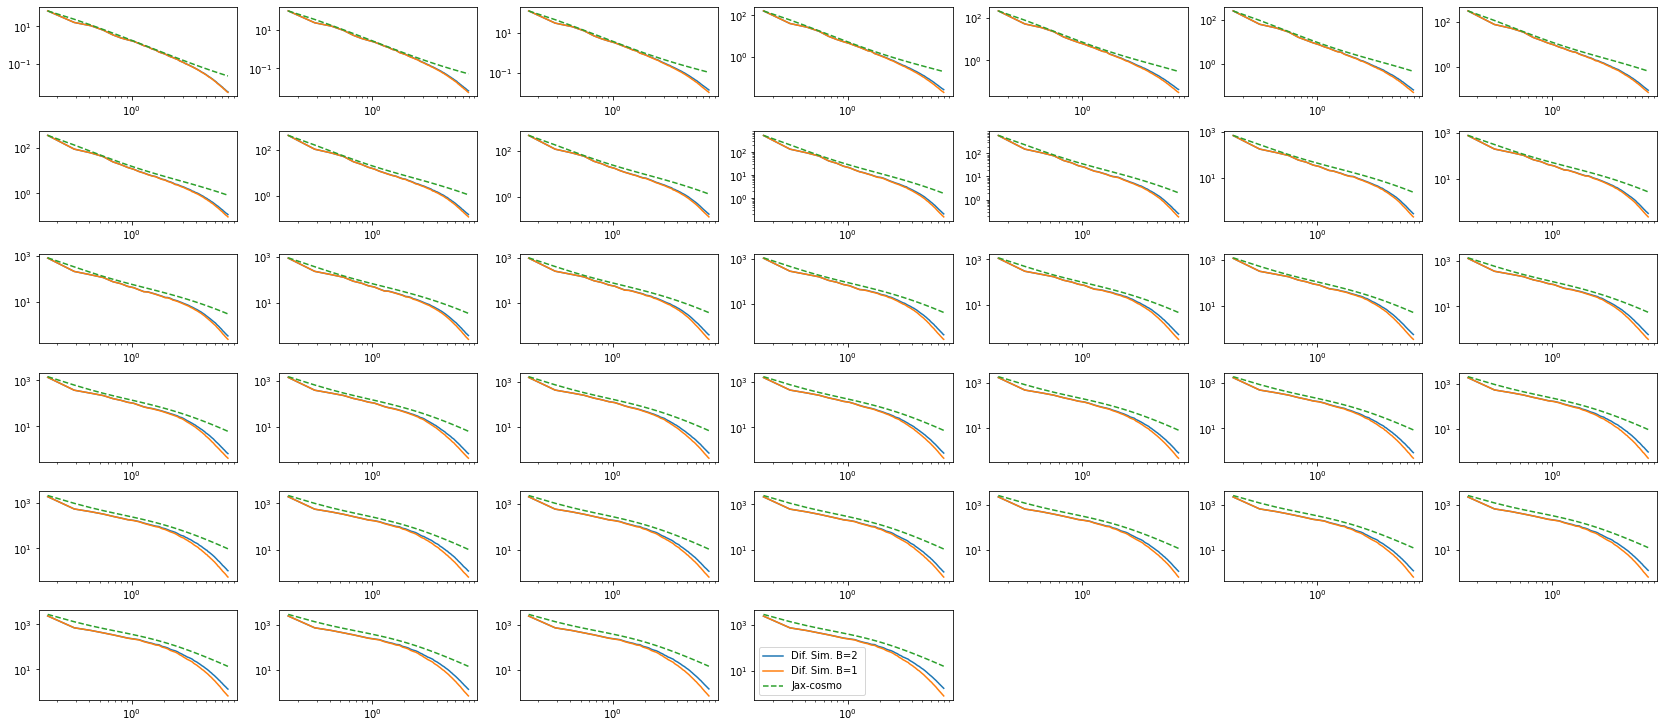

In [40]:
fig =plt.figure(figsize=figsize, constrained_layout=True)
figsize = (23, 10)
cols = 7
rows =6
axs = fig.subplots(rows, cols)
axs = trim_axs(axs, len(pk_array2))
for ax, p in zip(axs, pk_array2):
    #ax.set_title('markevery=%s' % str(case))
    ax.loglog(k, p,label='Dif. Sim. B=2 ')
for ax, pi in zip(axs, pk_array1):
    ax.loglog(k, pi,label='Dif. Sim. B=1 ')
for ax, pj in zip(axs, pk_jax1):
    ax.loglog(k, pj,'--',label='Jax-cosmo')
legend(loc='lower left')
fig.savefig('full_figure.png',dpi=250)

In [41]:
pickle.dump(
      {
          'pk_array1': pk_array1,
          'pk_array2': pk_array2,
          'k':k,
          'pk_jax': pk_jax,
      }, open("nbody_pm1_2_new", "wb"))